In [ ]:
from __future__ import division, print_function
%matplotlib inline

# Measuring chromatin fluorescence

Goal: we want to quantify the amount of a particular protein (red fluorescence) localized on the centromeres (green) versus the rest of the chromosome (blue).

![Chromosomes](images/chromosomes.jpg)

The main challenge here is the uneven illumination, which makes isolating the chromosomes a struggle.

In [1]:
import numpy as np
from matplotlib import cm, pyplot as plt
import skdemo
plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.interpolation'] = 'none'

(<matplotlib.axes.AxesSubplot at 0x1087fc8d0>,
 <matplotlib.axes.AxesSubplot at 0x10967cd90>)

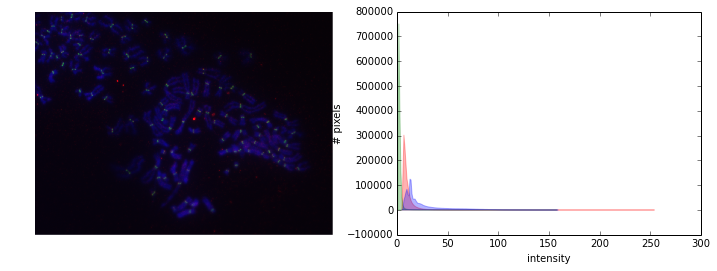

In [2]:
from skimage import io
image = io.imread('images/chromosomes.tif')
skdemo.imshow_with_histogram(image)

Let's separate the channels so we can work on each individually.

In [3]:
protein, centromeres, chromosomes = image.transpose((2, 0, 1))

Getting the centromeres is easy because the signal is so clean:

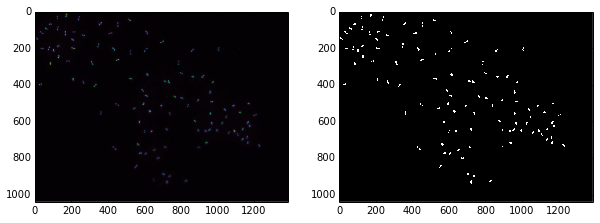

In [4]:
from skimage.filter import threshold_otsu
centromeres_binary = centromeres > threshold_otsu(centromeres)
skdemo.imshow_all(centromeres, centromeres_binary)

But getting the chromosomes is not so easy:

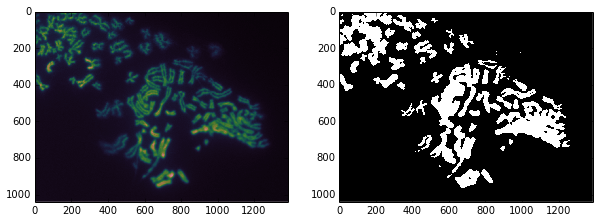

In [5]:
chromosomes_binary = chromosomes > threshold_otsu(chromosomes)
skdemo.imshow_all(chromosomes, chromosomes_binary)

Let's try using an adaptive threshold:

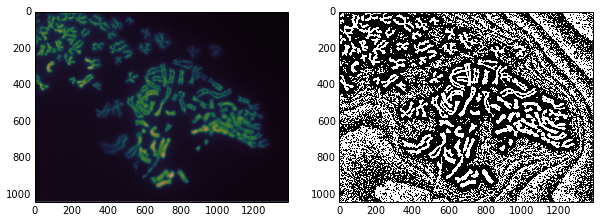

In [6]:
from skimage.filter import threshold_adaptive
chromosomes_adapt = threshold_adaptive(chromosomes, block_size=51)
# Question: how did I choose this block size?
skdemo.imshow_all(chromosomes, chromosomes_adapt)

Not only is the uneven illumination a problem, but there seem to be some artifacts due to the illumination pattern!

**Exercise:** Can you think of a way to fix this?

(Hint: in addition to everything you've learned so far, check out [`skimage.morphology.remove_small_objects`](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects))

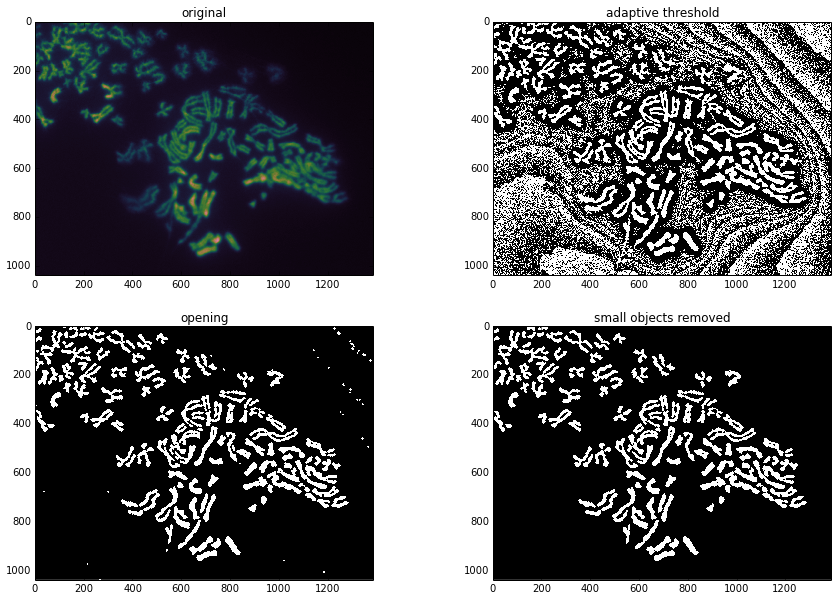

In [7]:
from skimage.morphology import (opening, selem,
                                remove_small_objects)
d = selem.diamond(radius=4)
chr0 = opening(chromosomes_adapt, d)
chr1 = remove_small_objects(chr0.astype(bool), 256)
images = [chromosomes, chromosomes_adapt, chr0, chr1]
titles = ['original', 'adaptive threshold',
          'opening', 'small objects removed']
skdemo.imshow_all(*images, titles=titles, shape=(2, 2))

Now that we have the centromeres and the chromosomes, it's time to do the science: get the distribution of intensities in the red channel using both centromere and chromosome locations.

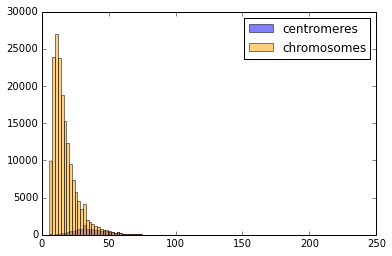

In [8]:
# Replace "None" below with the right expressions!
centromere_intensities = protein[centromeres_binary]
chromosome_intensities = protein[chr1]
all_intensities = np.concatenate((centromere_intensities,
                                  chromosome_intensities))
minint = np.min(all_intensities)
maxint = np.max(all_intensities)
bins = np.linspace(minint, maxint, 100)
plt.hist(centromere_intensities, bins=bins, color='blue',
         alpha=0.5, label='centromeres')
plt.hist(chromosome_intensities, bins=bins, color='orange',
         alpha=0.5, label='chromosomes')
plt.legend(loc='upper right')
plt.show()